In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [5]:
def full_mean_photons_cav(κ, γ, r, g, nT, nc, Δ):
    num = (κ + γ) * nT * ((κ + γ) * r / 4 + g ** 2 + r ** 2 / 4 + 1j * r * Δ / 2) + g * r ** 2 * nc
    den = (-Δ + 1j * (r + κ + γ) / 2) * ((κ + γ) * r / 4 + g ** 2 + 1j * r * Δ / 2)
    return 0.5 * np.abs(num / den)

In [6]:
# Define parameters
ωc = 2.87 * 2 * np.pi * 1e9
κ = 0
P = 0.8
nc = 0.5 * (1 - P) / P
T = 5
nT = photons_from_temp(ωc, T)

In [7]:
# Define sweep parameters
g = np.logspace(4, 8, 1000)
Q = np.logspace(4, 8, 1000)

# Create meshgrid
gm, Qm = np.meshgrid(g, Q)

# Calculate r and γ
r = 2 * gm
γ = ωc / Qm

In [8]:
# Calculate the number of photons
nbar = full_mean_photons_cav(κ, γ, r, gm, nT, nc, 0)

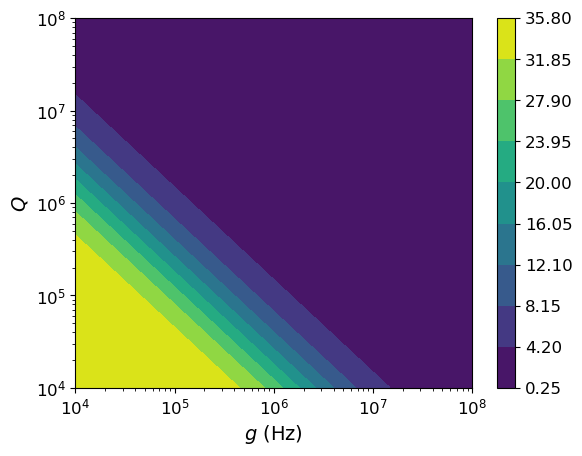

In [9]:
plt.contourf(gm, Qm, nbar, np.linspace(nbar.min(), nbar.max(), 10))
plt.xlabel("$g$ (Hz)")
plt.ylabel("$Q$")
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [10]:
P_vals = np.linspace(0.1, 1, 1000)
nc_vals = 0.5 * (1 - P_vals) / P_vals

In [11]:
# Define g and Q values we want to use here
g_vals = np.array([1e5, 1e6, 1e7])
Q_vals = np.array([1e5, 1e6, 1e7])

# Set up list for storing nbar values
nbars = []

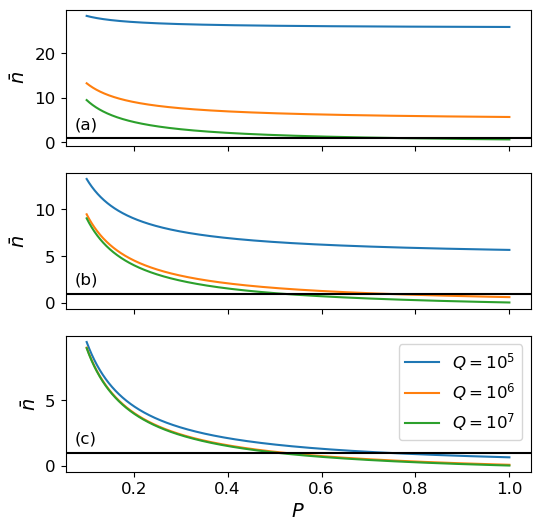

In [12]:
fig = plt.figure(1, figsize=(6, 6))
ax = fig.subplots(3, 1, sharex='all')
for i in range(g_vals.shape[0]):
    nbars = []
    for j in range(Q_vals.shape[0]):
        nbars.append(full_mean_photons_cav(κ, ωc / Q_vals[j], 2*g_vals[i], g_vals[i], nT, nc_vals, 0))
        ax[i].plot(P_vals, nbars[j], label="$Q=10^" + str(j+5) + "$")
    ax[i].set_ylabel("$\\bar{n}$")
    ax[i].axhline(y=1, color='k')
ax[2].set_xlabel("$P$")
ax[2].legend()
ax[0].text(0.075, 3, '(a)')
ax[1].text(0.075, 2, '(b)')
ax[2].text(0.075, 1.75, '(c)')
fig.savefig("nbar_vs_P_for_diff_gQ.png", format='png', dpi=300)

In [13]:
# Want to determine more precisely the polarization required to get below nbar = 1
for i in range(g_vals.shape[0]):
    for j in range(Q_vals.shape[0]):
        for k in range(P_vals.shape[0]):
            n = full_mean_photons_cav(κ, ωc / Q_vals[j], 2*g_vals[i], g_vals[i], nT, nc_vals[k], 0)
            if n < 1:
                print("g=" + str(g_vals[i]) + ", Q=" + str(Q_vals[j]) + ", P=" + str(P_vals[k]))
                break
    

g=100000.0, Q=10000000.0, P=0.7306306306306306
g=1000000.0, Q=1000000.0, P=0.7306306306306306
g=1000000.0, Q=10000000.0, P=0.5162162162162163
g=10000000.0, Q=100000.0, P=0.7306306306306306
g=10000000.0, Q=1000000.0, P=0.5162162162162163
g=10000000.0, Q=10000000.0, P=0.5018018018018018


Matt suggested seeing if we could use cooperativity as our parameter of interest instead, as it relates g to Q.  Then $C = \frac{g^2}{(\kappa+\gamma)r} = \frac{Qg}{Q\kappa+\omega_c}\frac{g}{r}$.  If $\kappa=0$ and $r=\alpha g$, then $C = \frac{gQ}{\alpha \omega_c}$.

In [14]:
C = gm ** 2 / ((κ + γ) * r)

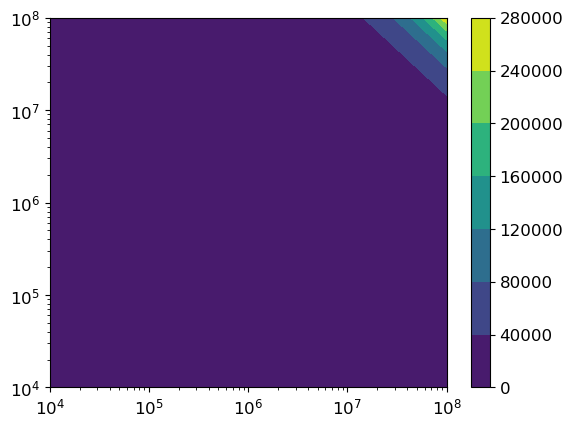

In [15]:
plt.contourf(gm, Qm, C)
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [16]:
# Redefine γ and r for this calculation
r = g
γ = ωc / np.array([1e4, 1e5, 1e6, 1e7, 1e8])

In [17]:
nbars = np.array([full_mean_photons_cav(κ, _, r, g, nT, nc, 0) for _ in γ])

In [18]:
C = np.array([g ** 2 / ((κ + _) * r) for _ in γ])

In [19]:
nbars.shape, C.shape

((5, 1000), (5, 1000))

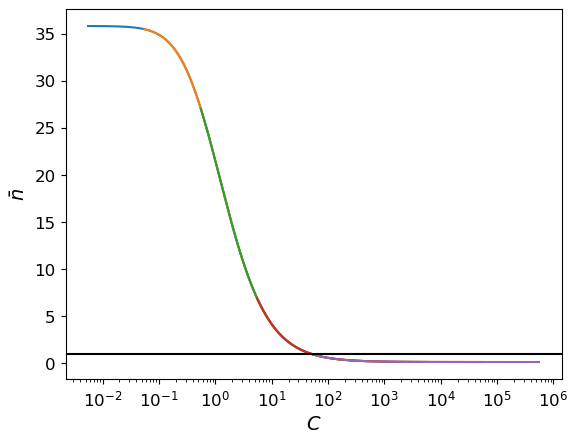

In [20]:
for i in range(γ.shape[0]):
    plt.plot(C[i], nbars[i])
plt.axhline(y=1, color='k')
plt.xlabel("$C$")
plt.ylabel("$\\bar{n}$")
plt.xscale('log')

Seems like this might work as a figure, but I'm not sure that its more informative than the other

In [21]:
vb = 3.62e-8
Bs = np.sqrt(6.626e-34 * 10e9 / (2 * vb / 1.26e-6))
print(Bs)

1.073845261855189e-11


Chuck's paper suggests that superconducting resonator cavities could achieve a Q of $10^{10}$.  What would the cooling look like then?

In [27]:
Q = 1e10
γ =  ωc / Q

g = np.logspace(1, 8, 1000)
r = g

P = 0.8
nc = 0.5 * (1 - P) / P

In [28]:
nbar_high_Q = full_mean_photons_cav(κ, γ, r, g, nT, nc, 0)

Text(0, 0.5, '$\\bar{n}$')

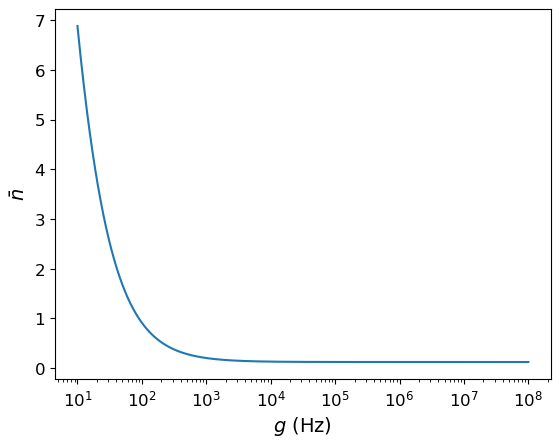

In [29]:
plt.semilogx(g, nbar_high_Q)
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\bar{n}$")

Create some plots looking at the behavior of mode cooling using r/g instead

In [53]:
# Set our values for g and Q
g = np.array([1e5, 1e6, 1e7, 1e8, 1e9])
Q = np.array([1e5, 1e6, 1e7, 1e8])
γ = ωc / Q

35.79937923012842 35.779317165288376
35.79937923012842 35.59968389375274
35.79937923012842 33.89781402999272
35.79937923012842 22.93404266078261
35.79937923012842 5.416258774886024


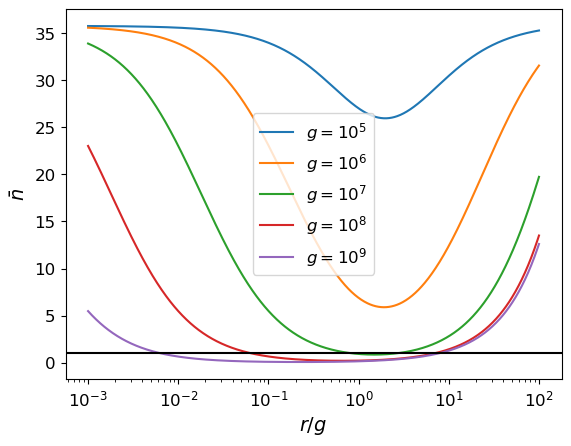

In [54]:
# Create array of r / g values to look at
r_ov_g = np.logspace(-3, 2, 1000)
for i in range(g.shape[0]):
    temp_nbar = full_mean_photons_cav(κ, γ[0], r_ov_g * g[i], g[i], nT, nc, 0)
    print(nT, temp_nbar[1])
    plt.semilogx(r_ov_g, temp_nbar, label="$g=10^"+str(i+5)+"$")

plt.axhline(y=1, color='k')
plt.xlabel("$r/g$")
plt.ylabel("$\\bar{n}$")
plt.legend()

35.79937923012842 35.797357155387566
35.79937923012842 35.77916875666345
35.79937923012842 35.59829618495723
35.79937923012842 33.88530973858553
35.79937923012842 22.87694617701292


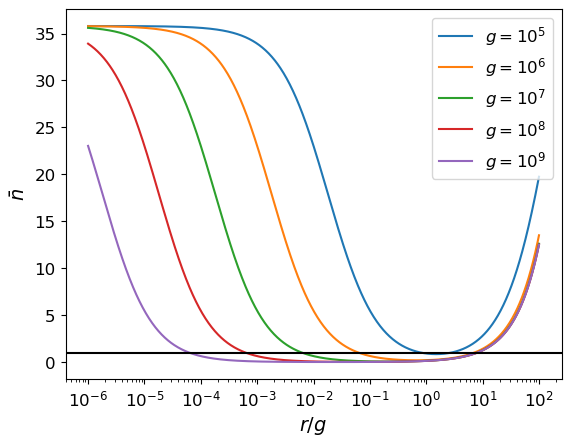

In [56]:
# Create array of r / g values to look at
r_ov_g = np.logspace(-6, 2, 1000)
for i in range(g.shape[0]):
    temp_nbar = full_mean_photons_cav(κ, γ[2], r_ov_g * g[i], g[i], nT, nc, 0)
    print(nT, temp_nbar[1])
    plt.semilogx(r_ov_g, temp_nbar, label="$g=10^"+str(i+5)+"$")

plt.axhline(y=1, color='k')
plt.xlabel("$r/g$")
plt.ylabel("$\\bar{n}$")
plt.legend()

So the higher $g$ gets, the lower you want the ratio $r/g$ to reach the minimum number of photons in the cavity mode.  Increasing $Q$ seems to exacerbate this effect